In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
# Read the dataframes
df1 = pd.read_csv("production.csv")
df = pd.read_csv("weather_info.csv")

df1.drop([0,1,2,3])
# Create a new column 'location' in df to store combined lat_lon values
df['location'] = df['lat'].astype(str) + '_' + df['lon'].astype(str)

# Get unique lat_lon combinations
lat_lon_values = df["location"].unique()

# Drop the 'location' column
df.drop("location", axis=1, inplace=True)

# Store the original columns
original_columns = df.columns.tolist()

# Create a list to store dataframes with new columns
dfs_with_new_columns = []

# Iterate over the original columns
for column_name in original_columns[4:]:
    # Create a dataframe to store new columns for the current column
    new_columns_df = pd.DataFrame(index=df.index)

    # Iterate over the lat_lon combinations
    for location in lat_lon_values:
        lat, lon = location.split("_")
        new_column_name = f"{column_name}_{location}"
        new_columns_df[new_column_name] = np.where((df['lat'] == float(lat)) & (df['lon'] == float(lon)), df[column_name], np.nan)

    # Append the dataframe to the list
    dfs_with_new_columns.append(new_columns_df)

# Concatenate all dataframes along the columns axis
df_with_new_columns = pd.concat([df] + dfs_with_new_columns, axis=1)

#df_with_new_columns.fillna(0, inplace=True)

df_with_new_columns.drop(['lat', 'lon', 'DSWRF_surface',"TCDC_low.cloud.layer","TCDC_middle.cloud.layer","TCDC_high.cloud.layer","TCDC_entire.atmosphere","USWRF_top_of_atmosphere","CSNOW_surface","DLWRF_surface","USWRF_surface","TMP_surface"], axis=1, inplace=True)

wide_df = df_with_new_columns.pivot_table(index=['date', 'hour'])

wide_df.reset_index(inplace=True)


wide_df['date'] = pd.to_datetime(wide_df['date'])
wide_df = wide_df.sort_values(by=['date', 'hour'])
wide_df.fillna(0, inplace=True)

df1['date'] = pd.to_datetime(df1['date'])
df1 = df1.sort_values(by=['date', 'hour'])
df1.fillna(0, inplace=True)

merged_df = pd.merge(wide_df, df1, how='outer', on=["date", "hour"])

merged_df.to_excel('output1.xlsx', index=False)



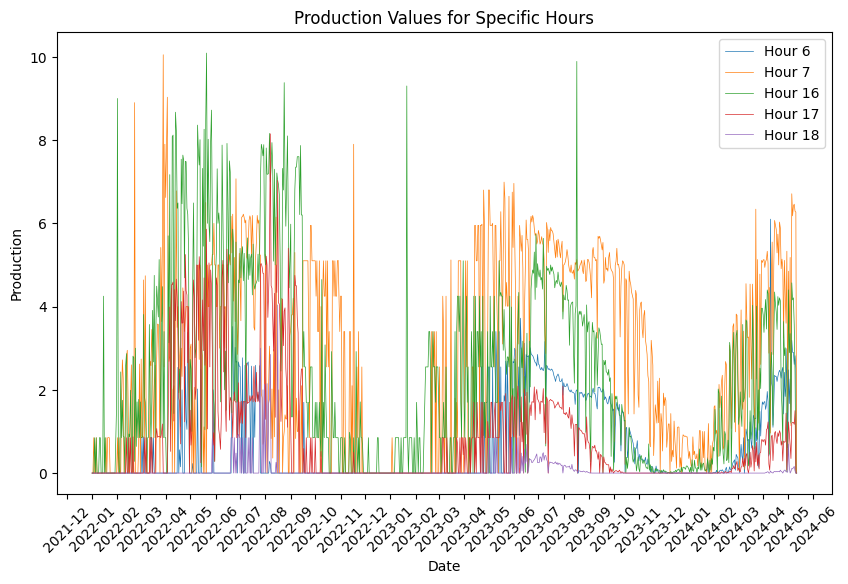

In [4]:
desired_hours = [6,7,16,17,18]
# Filter the dataframe by desired hours
filtered_df = merged_df[merged_df['hour'].isin(desired_hours)]

# One-hot encode month and hour
month_encoded = pd.get_dummies(filtered_df['date'].dt.month, prefix='month', drop_first=True)
hour_encoded = pd.get_dummies(filtered_df['hour'], prefix='hour', drop_first=True)

# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([filtered_df, month_encoded, hour_encoded], axis=1)

#Filter the dataframe by desired hours
filtered_df1 = df_encoded[df_encoded['hour'].isin(desired_hours)]
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot production values for each hour
for hour in desired_hours:
    hour_data = filtered_df1[filtered_df1['hour'] == hour]
    plt.plot(hour_data['date'], hour_data['production'], label=f'Hour {hour}',linewidth=0.5)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Production Values for Specific Hours')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))

plt.legend()

# Show the plot
plt.show()